# LAB 597: Make More Informed Decisions with Geospatial Intelligence

Welcome! In this lab you will take your first steps with geospatial data and see how satellite imagery can answer a real community question: *How hot are school campuses, and how might greening help?* You do **not** need prior GIS or remote sensing experience—each concept is introduced briefly and applied immediately.



## What Is Geospatial Data?

Geospatial data is any information tied to a location on Earth. Instead of just rows and columns, we also have shapes (points, lines, polygons) or pixels that map to latitude/longitude. Examples:

- A point: the centroid of a school

- A polygon: the outline (footprint) of a campus

- A raster (grid): a satellite image where each pixel stores a value (like temperature or vegetation)



By combining these, we can ask location-based questions: Which schools have the least vegetation? Which campuses run hottest in summer? Where should we prioritize cooling investments?



## Microsoft Planetary Computer (MPC)

The Microsoft Planetary Computer hosts curated, analysis-ready environmental datasets (imagery, climate layers, elevation, land cover, and more) and provides APIs + scalable infrastructure so you can:

1. Discover trusted geospatial datasets via STAC (a common catalog standard)

2. Access them efficiently as Cloud-Optimized GeoTIFFs (stream only the pixels you need)

3. Combine multiple data sources to solve real-world sustainability and resilience problems



In this lab we will use MPC to pull:

- **NAIP aerial imagery** for a clear visual + vegetation (NDVI) indicator

- **Landsat thermal data** for land surface temperature (LST)



## The Basic Analysis Workflow

This lab mirrors a repeatable pattern used in geospatial analytics at larger scales:

1. **Identify facilities (areas) of interest** – We load all school footprints and select one pilot campus.

2. **Gather the required data** – Query MPC for imagery (NAIP) and temperature (Landsat) that intersect the campus.

3. **Run a model or calculation** – Compute vegetation (NDVI) and mean land surface temperature from clipped pixels, applying quality masks.

4. **Present findings** – Summarize and visualize: How does temperature vary across multiple summer observations? What might that imply for greening strategies?



> At enterprise or “planetary” scale the exact same pattern applies—you just automate it across thousands of sites and many time periods, then store aggregated metrics for decision-makers.



## What You Will Do Here

- Load and inspect a school footprint dataset

- Clip high‑resolution imagery and thermal pixels to a single campus

- Calculate NDVI (vegetation index) and mean land surface temperature

- Explore multiple summer observations to understand temporal variation



## Why It Matters

Urban heat and equitable access to cool, green spaces are public health issues. Geospatial intelligence transforms raw pixels into actionable metrics that help communities decide **where** to invest and **why**.



---

To start, let's install the required python packages into the computing environment. 

In [1]:
# Install session dependencies if needed (uncomment when running locally)
%pip install --quiet planetary-computer pystac-client stackstac rioxarray geopandas shapely rasterio folium tqdm contextily

Note: you may need to restart the kernel to use updated packages.


Next, we will import those function into memory and make them available for future use.

In [42]:
from pathlib import Path
import os
from typing import Tuple
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import planetary_computer as pc
import rasterio
import rioxarray
import xarray as xr
from pyproj import Transformer
from pystac_client import Client
from shapely.geometry import shape, mapping
from shapely.ops import transform
from rasterio.mask import mask

For this lab, we have used the [Open Street Map](https://www.openstreetmap.org/#map=5/38.01/-95.84) project to generate a list of schools in the Phoenix area. These schools were put into a [GeoJSON format](https://en.wikipedia.org/wiki/GeoJSON) and saved as a file we will use.  

In [3]:
# Load the school footprints (expects phoenix_schools.geojson alongside this notebook)
notebook_dir = Path(__file__).parent if '__file__' in globals() else Path().resolve()
schools_path = next((p for p in [notebook_dir / 'phoenix_schools.geojson', notebook_dir / 'lab' / 'phoenix_schools.geojson'] if p.exists()), None)
if schools_path is None:
    raise FileNotFoundError("Place phoenix_schools.geojson in this folder (or lab/) before running the lab.")
os.environ.setdefault("OGR_GEOMETRY_ACCEPT_UNCLOSED_RING", "YES")
schools_raw = gpd.read_file(schools_path, engine='pyogrio', on_invalid='fix')
schools_gdf = schools_raw.to_crs('EPSG:4326')
print(f"Total school features: {len(schools_gdf):,}")
schools_gdf[['name', 'amenity']].head()

Total school features: 462


,name,amenity
0,Grand Canyon University,university
1,None,university
2,Biltmore Preparatory Academy,school
3,Roosevelt School,school
4,Madison School Number Two,school


Now that we have a list of the schools in Phoenix, we are going to randomly select one to test the workflow. This code takes the selected school and prints out its properties.

In [51]:
# Configuration for random pilot selection
RANDOM_SEED = None  # set to None for a different random school each run
FORCE_SCHOOL_NAME = None  # set to a school name string to override randomness

# Pick the pilot school record (random by default so we can test extensibility)
if FORCE_SCHOOL_NAME:
    pilot_school_name = FORCE_SCHOOL_NAME
else:
    available_names = schools_gdf['name'].dropna().unique()
    if len(available_names) == 0:
        raise ValueError("No named schools available to sample.")
    available_names = np.sort(available_names)
    rng = np.random.default_rng(RANDOM_SEED)
    pilot_school_name = rng.choice(available_names)

if 'pilot_row' not in globals() or pilot_row['name'] != pilot_school_name:
    pilot_candidates = schools_gdf[schools_gdf['name'] == pilot_school_name].copy()
    if pilot_candidates.empty:
        raise ValueError(f"Couldn't find {pilot_school_name} in the GeoJSON.")
    pilot_candidates['area_m2'] = pilot_candidates.geometry.to_crs('EPSG:3857').area
    pilot_row = pilot_candidates.sort_values('area_m2', ascending=False).iloc[0]

pilot_shape = pilot_row.geometry
pilot_bounds = pilot_shape.bounds
centroid_projected = gpd.GeoSeries([pilot_shape], crs='EPSG:4326').to_crs('EPSG:3857').centroid
pilot_centroid = centroid_projected.to_crs('EPSG:4326').iloc[0]

print(f"Pilot school: {pilot_row['name']} (random seed: {RANDOM_SEED})")
print(pilot_row[['addr:street', 'addr:postcode']])
print(f"Bounds (xmin, ymin, xmax, ymax): {pilot_bounds}")
print(f"Centroid (lon, lat): ({pilot_centroid.x:.6f}, {pilot_centroid.y:.6f})")

Pilot school: Esperanza Elementary School (random seed: None)
addr:street      West McDowell Road
addr:postcode                 85009
Name: 150, dtype: object
Bounds (xmin, ymin, xmax, ymax): (-112.1257765, 33.4635549, -112.1241018, 33.465863)
Centroid (lon, lat): (-112.125142, 33.464505)


Given the boundaries of this school, lets take a look at it on a map. 

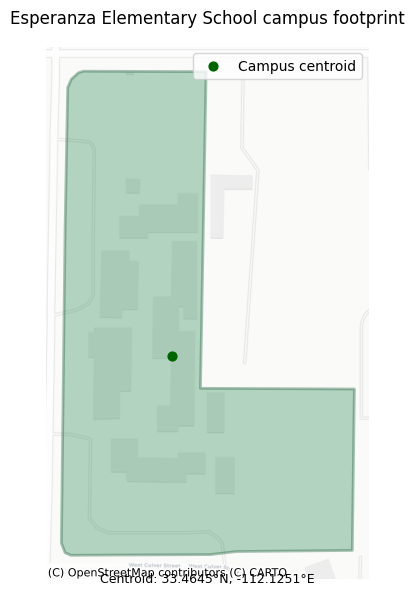

In [52]:
# Quick visualization of the pilot school footprint on a tiled basemap
pilot_gdf = gpd.GeoDataFrame({'name': [pilot_school_name]}, geometry=[pilot_shape], crs='EPSG:4326')
pilot_gdf_3857 = pilot_gdf.to_crs(epsg=3857)
pilot_centroid_3857 = pilot_gdf_3857.geometry.centroid.iloc[0]

fig, ax = plt.subplots(figsize=(6, 6))
pilot_gdf_3857.plot(ax=ax, facecolor='#2e8b57', edgecolor='#115533', alpha=0.35, linewidth=2)
ax.scatter(pilot_centroid_3857.x, pilot_centroid_3857.y, color='darkgreen', s=40, label='Campus centroid')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title(f"{pilot_school_name} campus footprint", fontsize=12)
ax.legend(loc='upper right')
ax.set_axis_off()
caption = f"Centroid: {pilot_centroid.y:.4f}°N, {pilot_centroid.x:.4f}°E"
# plt.suptitle('Only the campus polygon is rendered; background tiles provide familiar context.', fontsize=9, y=0.94)
plt.figtext(0.5, 0.02, caption, ha='center', fontsize=9)
plt.tight_layout()
plt.show()

Microsoft's Planetary Computer [Open Data Catalog](https://planetarycomputer.microsoft.com/catalog) contains 100's of datasets about the earth all organized in a common catalog format called the Spatio Temporal Asset Catalog, or [STAC](https://stacspec.org/en/). 

This is where we will find the [Landsat](https://www.usgs.gov/faqs/what-landsat-satellite-program-and-why-it-important) data to measure the temperature of the various schools. 



However, to actually look at the buildings and landscaping of these schools, we will need high-resolution aerial imagery. The City of Phoenix commissions aircraft to complete this aerial survey every few years, and we need to put this data somewhere. 



In [53]:
# Helper functions for bounding boxes and STAC search
def expand_bounds(bounds: Tuple[float, float, float, float], buffer_degrees: float = 0.0008) -> Tuple[float, float, float, float]:
    xmin, ymin, xmax, ymax = bounds
    return (xmin - buffer_degrees, ymin - buffer_degrees, xmax + buffer_degrees, ymax + buffer_degrees)

def open_catalog():
    if '_pc_catalog' not in globals():
        globals()['_pc_catalog'] = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1', modifier=pc.sign_inplace)
    return globals()['_pc_catalog']

def search_planetary_computer(collection: str, bbox: Tuple[float, float, float, float], start: str, end: str, **search_kwargs):
    """Return the most recent STAC item intersecting the bbox and date range."""
    catalog = open_catalog()
    search_parameters = {
        'collections': [collection],
        'bbox': bbox,
        'datetime': f"{start}/{end}",
        'max_items': search_kwargs.pop('max_items', 20),
        'limit': search_kwargs.pop('limit', 20),
        'sortby': search_kwargs.pop('sortby', [{'field': 'properties.datetime', 'direction': 'desc'}]),
    }
    search_parameters.update(search_kwargs)
    results = catalog.search(**search_parameters).item_collection()
    if not results:
        raise ValueError(f'No items found for collection={collection} in the requested window.')
    return results[0]

In [54]:
# Locate NAIP and Landsat scenes covering the campus
temporal_start = '2023-01-01'
temporal_end = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
expanded_bounds = expand_bounds(pilot_bounds)
naip_item = search_planetary_computer('naip', expanded_bounds, temporal_start, temporal_end)

catalog = open_catalog()
landsat_cloud_query = {'eo:cloud_cover': {'lt': 20}}
landsat_search_limit = 60
landsat_candidates = []
landsat_asset_skip_log = []

required_common_assets_primary = {"qa_pixel"}
primary_lst_candidates_single = ("ST_B10", "ST_B11", "lwir")
fallback_lst_requirements_single = {"trad", "urad", "drad", "emis", "atran", "mtl.json"}

landsat_search = catalog.search(
    collections=['landsat-c2-l2'],
    bbox=expanded_bounds,
    datetime=f"{temporal_start}/{temporal_end}",
    query=landsat_cloud_query,
    limit=landsat_search_limit,
    max_items=landsat_search_limit,
    sortby=[{'field': 'properties.datetime', 'direction': 'desc'}],
    fields={'exclude': ['links', 'collection', 'assets.*.alternate']}
)

for candidate in landsat_search.items():
    asset_keys = set(candidate.assets.keys())
    if not required_common_assets_primary.issubset(asset_keys):
        landsat_asset_skip_log.append({
            'id': candidate.id,
            'datetime': candidate.datetime.isoformat(),
            'missing_assets': sorted(required_common_assets_primary - asset_keys)
        })
        continue
    if not any(name in asset_keys for name in primary_lst_candidates_single):
        missing_fallback = fallback_lst_requirements_single - asset_keys
        if missing_fallback:
            landsat_asset_skip_log.append({
                'id': candidate.id,
                'datetime': candidate.datetime.isoformat(),
                'missing_assets': sorted(missing_fallback)
            })
            continue
    landsat_candidates.append(candidate)
    if len(landsat_candidates) >= 12:
        break

if not landsat_candidates:
    if landsat_asset_skip_log:
        print("No Landsat items with required assets. Sample of missing asset diagnostics:")
        for entry in landsat_asset_skip_log[:10]:
            missing_list = ', '.join(entry['missing_assets']) or 'unknown'
            print(f"  - {entry['id']} ({entry['datetime']}): missing {missing_list}")
        if len(landsat_asset_skip_log) > 10:
            print(f"  ...and {len(landsat_asset_skip_log) - 10} more")
    raise ValueError("Unable to find Landsat candidates with the required thermal assets in the requested window.")

landsat_item = landsat_candidates[0]  # placeholder until data validation
print(f"NAIP item: {naip_item.id}")
print(f"Initial Landsat candidate pool size: {len(landsat_candidates)} (newest first)")
print(f"First candidate to validate: {landsat_item.id}")

NAIP item: az_m_3311240_nw_12_030_20230917_20240304
Initial Landsat candidate pool size: 12 (newest first)
First candidate to validate: LC08_L2SP_037037_20250923_02_T1


### See the campus from above
Here's the true-color NAIP scene so students can orient themselves with a familiar aerial view before diving into the analytics.

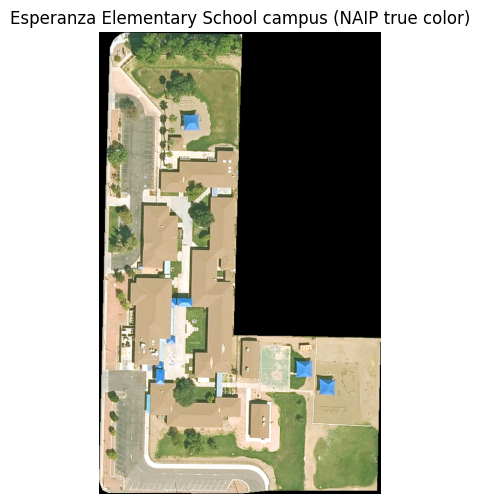

In [55]:
# Use COG-friendly windowed read + mask so we download only pixels intersecting the campus
naip_asset = naip_item.assets['image']
naip_href_signed = pc.sign(naip_asset.href)
with rasterio.open(naip_href_signed) as src:
    reproj = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True).transform
    pilot_shape_src = transform(reproj, pilot_shape)
    clipped_data, clipped_transform = mask(src, [mapping(pilot_shape_src)], crop=True)
    clipped_data = clipped_data.astype('float32')
    if src.nodata is not None:
        clipped_data = np.where(clipped_data == src.nodata, np.nan, clipped_data)
    naip_clip = xr.DataArray(
        clipped_data,
        dims=("band", "y", "x"),
        coords={"band": list(src.indexes)},
        name="naip_rgb",
    ).rio.write_transform(clipped_transform).rio.write_crs(src.crs)

# Display a contrast-stretched RGB image so students can recognize the campus
rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)], axis=-1)
if np.isfinite(rgb).any():
    low, high = np.nanpercentile(rgb[np.isfinite(rgb)], (2, 98))
    scale = max(high - low, 1)
    rgb_normalized = np.clip((rgb - low) / scale, 0, 1)
else:
    rgb_normalized = np.zeros_like(rgb, dtype="float32")

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rgb_normalized)
ax.set_title(f"{pilot_school_name} campus (NAIP true color)")
ax.axis("off")
plt.show()

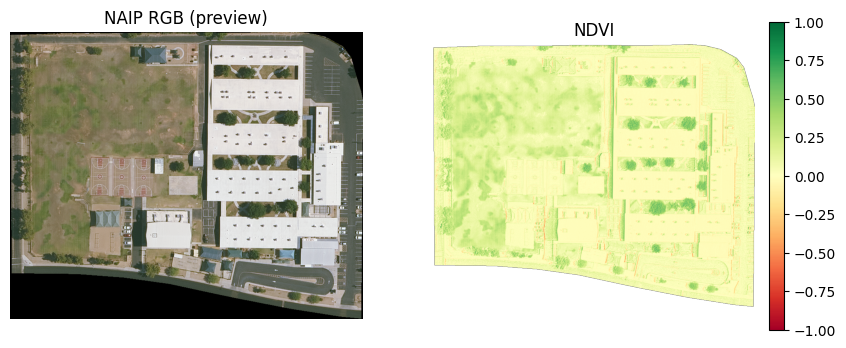

Mean NDVI over campus: 0.079


In [23]:
# Compute NDVI from NAIP (band order: R, G, B, NIR)
red = naip_clip.sel(band=1).astype('float32')
nir = naip_clip.sel(band=4).astype('float32')
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.where(np.isfinite(ndvi))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
naip_rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)])
naip_rgb_plot = np.transpose(naip_rgb, (1, 2, 0))
axes[0].imshow(np.clip(naip_rgb_plot / np.nanmax(naip_rgb_plot), 0, 1))
axes[0].set_title('NAIP RGB (preview)')
axes[0].axis('off')
ndvi_im = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title('NDVI')
axes[1].axis('off')
fig.colorbar(ndvi_im, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()
print(f"Mean NDVI over campus: {ndvi.mean().item():.3f}")

In [25]:
def load_landsat_lst(item, clip_geoms, clip_crs='EPSG:4326', enforce_limits=(-40.0, 70.0)) -> xr.DataArray:
    """Load Landsat Collection 2 L2 surface temperature, apply QA masking, and return LST in °C.

    The Microsoft Planetary Computer serves Landsat assets as Cloud-Optimized GeoTIFFs (COGs), so we
    read only the pixels that intersect the campus footprint using ``rasterio.mask`` instead of
    downloading full rasters. We preferentially use the calibrated ``ST_B10``/``ST_B11`` surface
    temperature bands. If they are missing, we fall back to the radiative transfer workflow.

    ``clip_geoms`` may contain GeoJSON dicts or shapely geometries expressed in ``clip_crs``.
    ``enforce_limits`` filters out unreasonable temperatures (defaults to -40°C..70°C).
    """
    def _to_shapes(geoms):
        shapes_out = []
        for geom in geoms:
            if isinstance(geom, dict):
                shapes_out.append(shape(geom))
            elif hasattr(geom, "__geo_interface__"):
                shapes_out.append(shape(geom.__geo_interface__))
            else:
                shapes_out.append(geom)
        return shapes_out

    def _scale_and_offset(band_meta):
        scale = band_meta.get('scale')
        if scale is None:
            scales = band_meta.get('scales')
            if isinstance(scales, (list, tuple)) and scales:
                scale = scales[0]
        if scale is None:
            scale = 1.0
        offset = band_meta.get('offset')
        if offset is None:
            offsets = band_meta.get('offsets')
            if isinstance(offsets, (list, tuple)) and offsets:
                offset = offsets[0]
        if offset is None:
            offset = 0.0
        return float(scale), float(offset)

    def _read_asset(asset, dtype='float32', fill_value=np.nan):
        href = pc.sign(asset.href)
        clip_shapes = _to_shapes(clip_geoms)
        with rasterio.open(href) as src:
            src_crs = src.crs
            if clip_crs and src_crs and clip_crs != src_crs.to_string():
                transformer = Transformer.from_crs(clip_crs, src_crs, always_xy=True)
                shapes_native = [transform(transformer.transform, geom) for geom in clip_shapes]
            else:
                shapes_native = clip_shapes
            shapes_geojson = [mapping(geom) for geom in shapes_native]
            data, out_transform = mask(src, shapes_geojson, crop=True, filled=False)
            mask_arr = np.ma.getmaskarray(data)
            data = data.astype(dtype)
            if data.shape[0] == 1:
                band_data = data[0]
                band_mask = mask_arr[0]
            else:
                band_data = data[0]
                band_mask = mask_arr[0]
            band_data = np.where(band_mask, fill_value, band_data)
            da = xr.DataArray(band_data, dims=("y", "x"))
            da = da.rio.write_transform(out_transform).rio.write_crs(src_crs)
            return da

    clip_shapes = _to_shapes(clip_geoms)
    if not clip_shapes:
        raise ValueError("clip_geoms must contain at least one geometry")

    qa_asset = item.assets.get('qa_pixel')
    if qa_asset is None:
        raise KeyError('qa_pixel asset is required for masking.')
    qa = _read_asset(qa_asset, dtype='uint32', fill_value=0)
    cloud_mask = (
        ((qa & (1 << 1)) != 0)
        | ((qa & (1 << 2)) != 0)
        | ((qa & (1 << 3)) != 0)
        | (((qa >> 4) & 0b11) >= 2)
        | (((qa >> 6) & 0b11) >= 2)
    )

    lst_asset = item.assets.get('ST_B10') or item.assets.get('ST_B11') or item.assets.get('lwir')
    lst_kelvin = None
    if lst_asset is not None:
        lst_da = _read_asset(lst_asset, dtype='float32', fill_value=np.nan)
        band_meta = lst_asset.extra_fields.get('raster:bands', [{}])[0]
        scale, offset = _scale_and_offset(band_meta)
        lst_kelvin = lst_da * scale + offset
        lst_kelvin = xr.where(cloud_mask, np.nan, lst_kelvin)

    if lst_kelvin is None:
        thermal_radiance_keys = ['trad', 'urad', 'drad', 'emis', 'atran']
        missing_keys = [key for key in thermal_radiance_keys if key not in item.assets]
        if missing_keys:
            raise KeyError(f"Unable to locate LST assets: {', '.join(missing_keys)}")

        clipped_assets = {}
        for key in thermal_radiance_keys:
            asset = item.assets[key]
            band_meta = asset.extra_fields.get('raster:bands', [{}])[0]
            scale, offset = _scale_and_offset(band_meta)
            da = _read_asset(asset, dtype='float32', fill_value=np.nan)
            clipped_assets[key] = da * scale + offset

        rad = clipped_assets['trad']
        up = clipped_assets['urad']
        down = clipped_assets['drad']
        emissivity = clipped_assets['emis'].clip(0.0001, 0.9999)
        transmittance = clipped_assets['atran'].clip(0.0001)

        radiance_surface = (rad - up - (1 - emissivity) * down) / (emissivity * transmittance)
        radiance_surface = xr.where((radiance_surface <= 0) | cloud_mask, np.nan, radiance_surface)
        # Determine thermal conversion constants
        mtl_href = pc.sign(item.assets['mtl.json'].href)
        mtl_response = requests.get(mtl_href, timeout=30)
        mtl_response.raise_for_status()
        metadata = mtl_response.json()['LANDSAT_METADATA_FILE']
        thermal_constants = metadata.get('LEVEL1_THERMAL_CONSTANTS', {})
        band_priority = [
            ('K1_CONSTANT_BAND_10', 'K2_CONSTANT_BAND_10'),
            ('K1_CONSTANT_BAND_11', 'K2_CONSTANT_BAND_11'),
            ('K1_CONSTANT_BAND_6_VCID_1', 'K2_CONSTANT_BAND_6_VCID_1'),
            ('K1_CONSTANT_BAND_6_VCID_2', 'K2_CONSTANT_BAND_6_VCID_2'),
        ]
        k1 = k2 = None
        for k1_key, k2_key in band_priority:
            if k1_key in thermal_constants and k2_key in thermal_constants:
                k1 = float(thermal_constants[k1_key])
                k2 = float(thermal_constants[k2_key])
                break
        if k1 is None or k2 is None:
            raise KeyError('Unable to determine thermal conversion parameters for this item')
        lst_kelvin = k2 / np.log((k1 / radiance_surface) + 1)

    lst_celsius = lst_kelvin - 273.15
    lst_celsius = lst_celsius.where(np.isfinite(lst_celsius))
    if enforce_limits is not None:
        min_c, max_c = enforce_limits
        lst_celsius = lst_celsius.where((lst_celsius >= min_c) & (lst_celsius <= max_c))
    return lst_celsius

In [46]:
# Clip the first Landsat candidate to the campus and summarize mean surface temperature
clip_geoms_geojson = [mapping(pilot_shape)]
first_lst = load_landsat_lst(landsat_item, clip_geoms_geojson)
valid_pixels = int(np.isfinite(first_lst).sum().item())
mean_temp_c = float(first_lst.mean().item()) if valid_pixels else float('nan')
mean_temp_f = (mean_temp_c * 9 / 5 + 32) if valid_pixels else float('nan')
try:
    from zoneinfo import ZoneInfo as _ZoneInfo
except ImportError:
    _ZoneInfo = None
acquisition_dt = getattr(landsat_item, 'datetime', None)
acquisition_local = None
if acquisition_dt is not None:
    if acquisition_dt.tzinfo is None:
        acquisition_dt = acquisition_dt.replace(tzinfo=timezone.utc)
    if _ZoneInfo is not None:
        acquisition_local = acquisition_dt.astimezone(_ZoneInfo('America/Phoenix'))
acquisition_date = acquisition_local.date() if acquisition_local else None
local_time_str = acquisition_local.strftime('%I:%M %p %Z') if acquisition_local else 'unknown local time'
print(f"First validated Landsat scene: {landsat_item.id}")
print(f"Valid pixels within campus mask: {valid_pixels:,}")
if valid_pixels:
    date_str = acquisition_date.isoformat() if acquisition_date else "unknown date"
    print(f"Mean campus land surface temperature on {date_str} at {local_time_str}: {mean_temp_c:.2f} °C / {mean_temp_f:.2f} °F")
else:
    print("No valid LST pixels after QA masking; check asset availability or cloud filters.")

First validated Landsat scene: LC08_L2SP_037037_20250923_02_T1
Valid pixels within campus mask: 56
Mean campus land surface temperature on 2025-09-23 at 11:04 AM MST: 48.97 °C / 120.15 °F


### Explore multi-summer land surface temperature
To understand seasonal variability, gather multiple cloud-free Landsat observations across several summers (June–August) and compare their campus-level land surface temperatures.

In [26]:
required_common_assets = {"qa_pixel"}
primary_lst_candidates = ("ST_B10", "ST_B11", "lwir")
fallback_lst_requirements = {"trad", "urad", "drad", "emis", "atran", "mtl.json"}

def item_has_required_assets(item):
    asset_keys = set(item.assets.keys())
    if not required_common_assets.issubset(asset_keys):
        return False, {"missing": sorted(required_common_assets - asset_keys)}
    if any(candidate in asset_keys for candidate in primary_lst_candidates):
        return True, None
    missing_fallback = fallback_lst_requirements - asset_keys
    if missing_fallback:
        return False, {"missing": sorted(missing_fallback)}
    return True, None

In [27]:
# Search for cloud-free Landsat summer observations across multiple years
start_year = 2015
end_year = 2025
desired_samples = 15
safety_multiplier = 6
search_limit = max(desired_samples * safety_multiplier, 60)

catalog = open_catalog()
summer_items = []
prefetched_lst_by_id = {}
seen_ids = set()
asset_skip_log = []
data_skip_log = []

required_common_assets = {"qa_pixel"}
primary_lst_candidates = ("ST_B10", "ST_B11", "lwir")
fallback_lst_requirements = {"trad", "urad", "drad", "emis", "atran", "mtl.json"}

search_start = f"{start_year}-06-01"
search_end = f"{end_year}-08-31"

search = catalog.search(
    collections=['landsat-c2-l2'],
    bbox=expanded_bounds,
    datetime=f"{search_start}/{search_end}",
    query={
        'landsat:cloud_cover_land': {'eq': 0},
        'eo:cloud_cover': {'eq': 0},
    },
    limit=search_limit,
    max_items=search_limit,
    sortby=[{'field': 'properties.datetime', 'direction': 'desc'}],
    fields={'exclude': ['links', 'collection', 'assets.*.alternate']}
)

for item in search.items():
    if item.id in seen_ids:
        continue
    seen_ids.add(item.id)
    if item.datetime.month not in (6, 7, 8):
        continue
    has_assets, details = item_has_required_assets(item)
    if not has_assets:
        asset_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'missing_assets': details.get('missing', [])
        })
        continue
    try:
        lst_candidate = load_landsat_lst(item, clip_geoms_geojson)
    except KeyError as exc:
        data_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'reason': f'Missing expected asset while loading LST: {exc}'
        })
        continue
    except requests.exceptions.RequestException as exc:
        data_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'reason': f'HTTP error while loading LST assets: {exc}'
        })
        continue
    except rasterio.errors.RasterioError as exc:
        data_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'reason': f'Raster read error while loading LST: {exc}'
        })
        continue
    if lst_candidate is None or np.isnan(lst_candidate).all():
        data_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'reason': 'All pixels masked or empty during prefetch validation'
        })
        continue
    valid_pixels = int(np.isfinite(lst_candidate).sum().item())
    if valid_pixels == 0:
        data_skip_log.append({
            'id': item.id,
            'datetime': item.datetime.isoformat(),
            'reason': 'No valid pixels after QA during prefetch validation'
        })
        continue
    prefetched_lst_by_id[item.id] = lst_candidate
    summer_items.append(item)
    if len(summer_items) >= desired_samples:
        break

if len(summer_items) < desired_samples:
    if asset_skip_log:
        print("Scenes skipped due to missing asset keys:")
        for entry in asset_skip_log[:10]:
            missing_list = ', '.join(entry['missing_assets']) or 'unknown'
            print(f"  - {entry['id']} ({entry['datetime']}): missing {missing_list}")
        if len(asset_skip_log) > 10:
            print(f"  ...and {len(asset_skip_log) - 10} more")
    if data_skip_log:
        print("Scenes skipped after attempting to load LST during validation:")
        for entry in data_skip_log[:10]:
            print(f"  - {entry['id']} ({entry['datetime']}): {entry['reason']}")
        if len(data_skip_log) > 10:
            print(f"  ...and {len(data_skip_log) - 10} more")
    raise ValueError(
        f"Only found {len(summer_items)} asset-complete, data-validated cloud-free summer scenes after filtering; consider relaxing filters or extending the date range."
    )

if asset_skip_log:
    print(f"Skipped {len(asset_skip_log)} scenes lacking required assets before validation.")
if data_skip_log:
    print(f"Skipped {len(data_skip_log)} scenes during data validation.")
print(
    f"Total asset-complete, data-validated summer candidates collected (searching {end_year}→{start_year} summers): {len(summer_items)}"
 )

Skipped 4 scenes during data validation.
Total asset-complete, data-validated summer candidates collected (searching 2025→2015 summers): 15


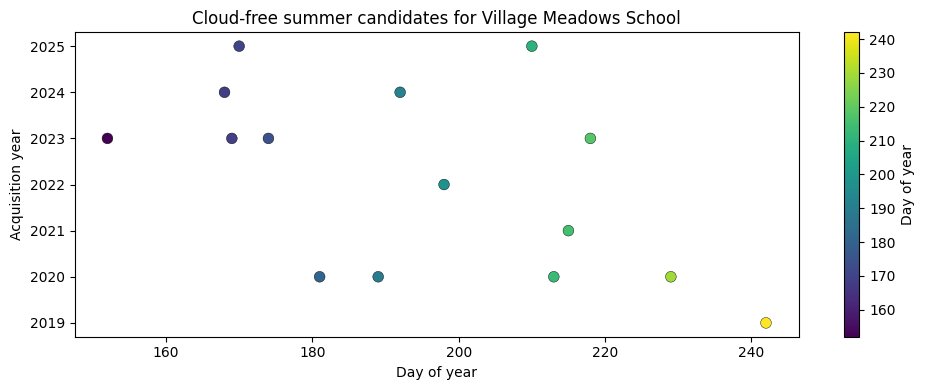

In [28]:
# Visualize the distribution of candidate scene dates
import calendar

summer_candidates_df = pd.DataFrame([
    {
        'datetime': item.datetime,
        'year': item.datetime.year,
        'month': calendar.month_abbr[item.datetime.month],
        'day_of_year': item.datetime.timetuple().tm_yday,
        'landsat_id': item.id,
        'satellite': item.properties.get('landsat:platform', 'unknown').upper(),
    }
    for item in summer_items
])

summer_candidates_df = summer_candidates_df.sort_values('datetime').reset_index(drop=True)
range_start = summer_candidates_df['datetime'].min()
range_end = summer_candidates_df['datetime'].max()
summer_candidates_df['days_since_start'] = (summer_candidates_df['datetime'] - range_start).dt.days
total_span_days = int((range_end - range_start).days)

fig, ax = plt.subplots(figsize=(10, 4))
scatter = ax.scatter(
    summer_candidates_df['day_of_year'],
    summer_candidates_df['year'],
    c=summer_candidates_df['day_of_year'],
    cmap='viridis',
    s=60,
    edgecolor='k',
    linewidth=0.3
 )
ax.set_title(f"Cloud-free summer candidates for {pilot_school_name}")
ax.set_xlabel('Day of year')
ax.set_ylabel('Acquisition year')
plt.colorbar(scatter, ax=ax, label='Day of year')
plt.tight_layout()
plt.show()

In [29]:
# Compute mean LST for each summer scene
records = []
skipped = []

for item in summer_items:
    lst = prefetched_lst_by_id.get(item.id)
    if lst is None:
        try:
            lst = load_landsat_lst(item, clip_geoms_geojson)
        except KeyError as exc:
            skipped.append({'landsat_id': item.id, 'reason': f'Missing expected asset while loading LST: {exc}'})
            continue
        except requests.exceptions.RequestException as exc:
            skipped.append({'landsat_id': item.id, 'reason': f'HTTP error: {exc}'})
            continue
        except rasterio.errors.RasterioError as exc:
            skipped.append({'landsat_id': item.id, 'reason': f'Raster read error: {exc}'})
            continue
    if lst is None or np.isnan(lst).all():
        skipped.append({'landsat_id': item.id, 'reason': 'All pixels masked or empty'})
        continue
    valid_pixels = int(np.isfinite(lst).sum().item())
    if valid_pixels == 0:
        skipped.append({'landsat_id': item.id, 'reason': 'No valid pixels after QA'})
        continue
    mean_temp = float(lst.mean().item())
    median_temp = float(lst.median().item())
    min_temp = float(lst.min().item())
    max_temp = float(lst.max().item())
    records.append({
        'datetime': item.datetime,
        'landsat_id': item.id,
        'mean_temp_c': mean_temp,
        'median_temp_c': median_temp,
        'min_temp_c': min_temp,
        'max_temp_c': max_temp,
        'valid_pixels': valid_pixels,
    })

if not records:
    raise ValueError("No usable LST scenes were found; consider relaxing filters or expanding the search window.")

summer_landsat_df = pd.DataFrame(records).sort_values('datetime').reset_index(drop=True)
overall_mean_c = summer_landsat_df['mean_temp_c'].mean()
print(f"Collected {len(summer_landsat_df)} cloud-free summer observations")
print(f"Overall mean LST (°C): {overall_mean_c:.2f}")
if skipped:
    print(f"Skipped {len(skipped)} scenes due to missing data:")
    for entry in skipped:
        print(f"  - {entry['landsat_id']}: {entry['reason']}")
display_columns = ['datetime', 'landsat_id', 'mean_temp_c', 'median_temp_c', 'min_temp_c', 'max_temp_c', 'valid_pixels']
summer_landsat_df[display_columns].head()

Collected 15 cloud-free summer observations
Overall mean LST (°C): 49.76


,datetime,landsat_id,mean_temp_c,median_temp_c,min_temp_c,max_temp_c,valid_pixels
0,2019-08-30 17:50:33.928263+00:00,LE07_L2SP_037037_20190830_02_T1,48.486748,48.675354,45.722198,51.450775,56
1,2020-06-29 17:34:49.118779+00:00,LE07_L2SP_037037_20200629_02_T1,49.570202,49.452957,47.916534,51.754974,56
2,2020-07-07 18:03:50.276682+00:00,LC08_L2SP_037037_20200707_02_T1,56.601749,56.562820,55.461945,58.346069,56
3,2020-07-31 17:32:51.484154+00:00,LE07_L2SP_037037_20200731_02_T1,54.184650,54.075836,51.587494,57.299011,56
4,2020-08-16 17:31:50.650224+00:00,LE07_L2SP_037037_20200816_02_T1,50.152145,50.370697,46.340851,52.995728,48


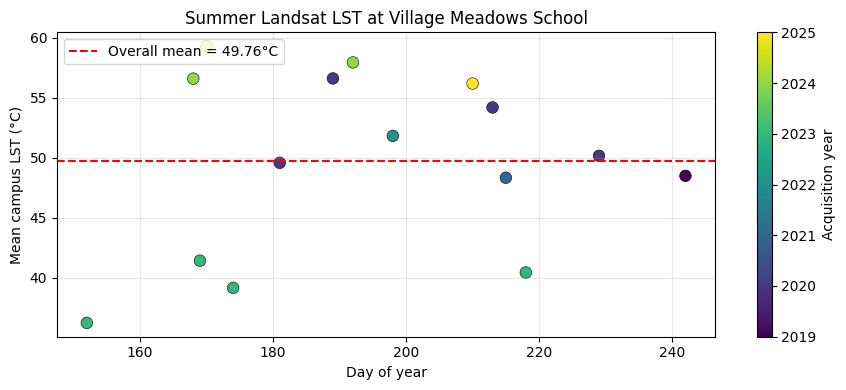

In [30]:
# Plot the temperature time series to show day-to-day variability
plot_df = summer_landsat_df.copy()
plot_df['day_of_year'] = plot_df['datetime'].dt.dayofyear
plot_df['year'] = plot_df['datetime'].dt.year

fig, ax = plt.subplots(figsize=(9, 4))
scatter = ax.scatter(
    plot_df['day_of_year'],
    plot_df['mean_temp_c'],
    c=plot_df['year'],
    cmap='viridis',
    s=70,
    edgecolor='k',
    linewidth=0.4,
    label=None
)
ax.axhline(overall_mean_c, color='red', linestyle='--', label=f'Overall mean = {overall_mean_c:.2f}°C')
ax.set_title(f"Summer Landsat LST at {pilot_school_name}")
ax.set_ylabel('Mean campus LST (°C)')
ax.set_xlabel('Day of year')
ax.grid(alpha=0.3)
legend_handles, legend_labels = ax.get_legend_handles_labels()
if legend_handles:
    ax.legend(loc='upper left')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Acquisition year')
plt.tight_layout()
plt.show()

## Next steps
- Validate the NAIP + Landsat selections across different years to build a time series.
- Compare campus-level NDVI and LST against city-wide percentiles to rank schools.
- Persist clipped rasters or summary stats so the workshop can scale to dozens of campuses without re-querying raw imagery.